French Road Accidents
==============
## __Time series and temporal evolution__

**Authors**:
> - Pablo Galán de Anta
> - Jennifer Pohlsen
> - Ilinca Suciu

**Project supervisor**: Lucas Varela - DataScientest

**Date**: 2023-12-08

Import the required modules and opening the merged data

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime, joblib
import statsmodels.api as sm
from itertools import product

Obtaining the date of the accident

In [2]:
# Year selector
def year_selector(year):
    import glob
    list = glob.glob('../data/accidents_*.csv')
    list = sorted(list)
    list_of_years = []
    for jj in list:
        list_of_years.append(int(jj[18:22]))
    list_of_years = np.array(list_of_years)
    file_list = np.array(list)[list_of_years >= year]
    concatenated_df = pd.concat([pd.read_csv(file_path) for file_path in file_list], ignore_index=True)

    return concatenated_df

df = year_selector(2013)

df['year'] = df['year'].astype('int64').astype('str')
df['month'] = df['month'].astype('int64').astype('str')
df['day'] = df['day'].astype('int64').astype('str')

df['yymm'] = df['year'] + '-' + df['month'].str.zfill(2)
df['date'] = df['yymm'] + '-' + df['day'].str.zfill(2)

df.drop('yymm', axis=1, inplace=True)

/tmp/ipykernel_7928/4220593292.py:11: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  concatenated_df = pd.concat([pd.read_csv(file_path) for file_path in file_list], ignore_index=True)
/tmp/ipykernel_7928/4220593292.py:11: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  concatenated_df = pd.concat([pd.read_csv(file_path) for file_path in file_list], ignore_index=True)
/tmp/ipykernel_7928/4220593292.py:11: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  concatenated_df = pd.concat([pd.read_csv(file_path) for file_path in file_list], ignore_index=True)


Getting the total number of accidents per date and the number of accidents per date per injury severity

In [3]:
df_to_pred = df[df['date'] >= '2022-12-01'] # Storing last period of 2022 in a new variable
df = df[df['date'] < '2022-12-01'] # Quiting the last period of 2022 for prediction

## __Total number of accidents per date__

In [4]:
season = 7 # Adjust the seasonality

In [5]:
accidents = df.groupby('date')['Num_Acc'].nunique()
del df

# Convert the index to a DateTimeIndex
accidents.index = pd.to_datetime(accidents.index)

# Same for the accidents to predict
acc_to_pred = df_to_pred.groupby('date')['Num_Acc'].nunique()
del df_to_pred

acc_to_pred.index = pd.to_datetime(acc_to_pred.index)

Text(0, 0.5, '# Accidents')

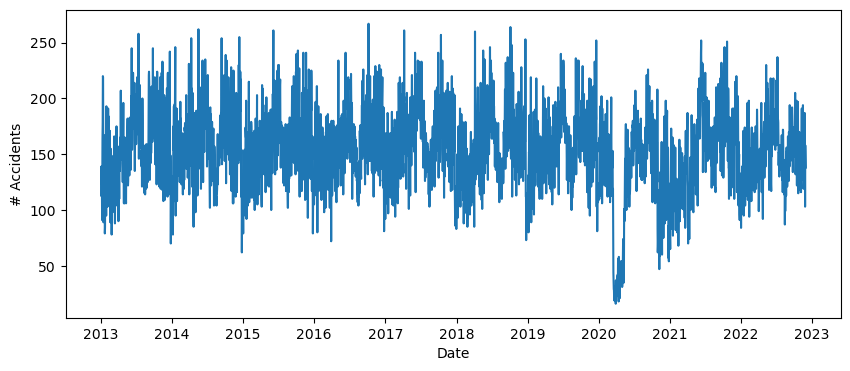

In [6]:
plt.figure(figsize=(10,4))
plt.plot(accidents)
plt.xlabel('Date')
plt.ylabel('# Accidents')

The seasonality presents a clear variation with time, so we can decompose the time series with a multiplicative fit

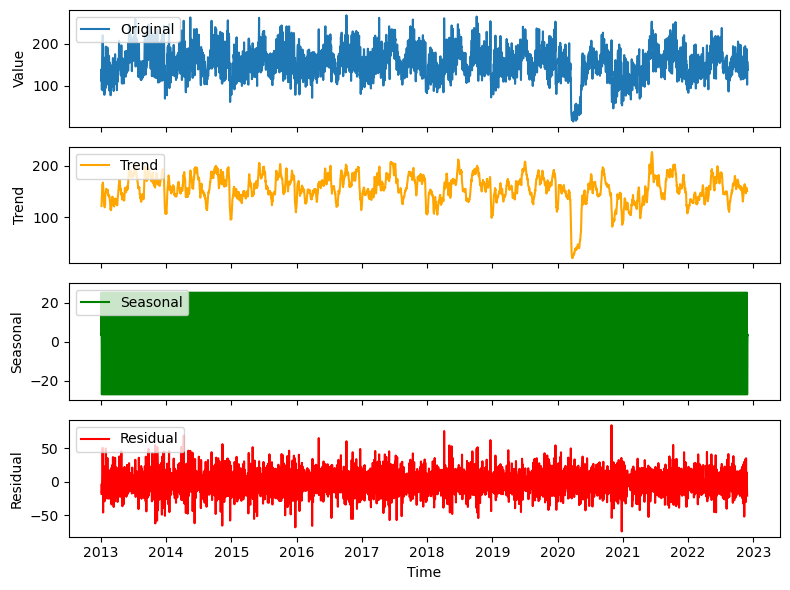

In [19]:
# Decompose the time series
res = seasonal_decompose(accidents, period=season, model='additive')

# Customize the plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

# Original time series
ax1.plot(accidents, label='Original')
ax1.legend(loc='upper left')
ax1.set_ylabel('Value')

# Trend component
ax2.plot(res.trend, label='Trend', color='orange')
ax2.legend(loc='upper left')
ax2.set_ylabel('Trend')

# Seasonal component
ax3.plot(res.seasonal, label='Seasonal', color='green')
ax3.legend(loc='upper left')
ax3.set_ylabel('Seasonal')
ax3.set_ylim(-30.,30)

# Residual component
ax4.plot(res.resid, label='Residual', color='red')
ax4.legend(loc='upper left')
ax4.set_ylabel('Residual')

# Set x-axis label
ax4.set_xlabel('Time')

#for ax in [ax1, ax2, ax3, ax4]:
#    ax.set_xlim('2013-01-01','2022-12-01')

plt.tight_layout()
#plt.savefig('../plots/time_series_decomp.png',bbox_inches='tight', dpi = 150)

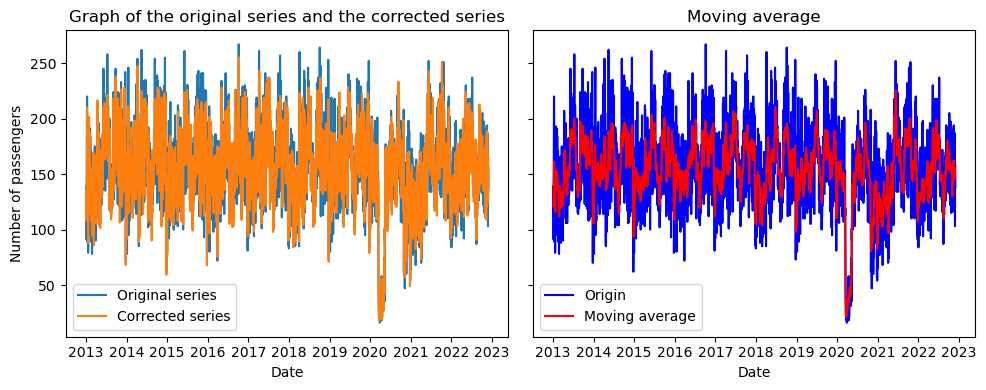

In [20]:
# We apply the seasonal_decompose function to accidents
accidentslog = np.log(accidents)

#We have a seasonality of period 7 days
accidents_ma = accidentslog.rolling(window = season, center = True).mean()

# Here we use the transform in log we are therefore in an additive model
mult = seasonal_decompose(accidentslog, model='additive', period=season)

# Seasonal coefficients are subtracted from the accidentslog series
cvs=accidentslog - mult.seasonal

# We go to the exponential to find the original series
x_cvs=np.exp(cvs)

# We display the series
fig, ax = plt.subplots(1,2,figsize=(10,4),sharey=True)
ax = ax.ravel()

ax[0].plot(accidents, label='Original series')
ax[0].plot(x_cvs, label='Corrected series') 

ax[0].set_title('Graph of the original series and the corrected series')
ax[0].set_xlabel('Date'); ax[1].set_xlabel('Date')
ax[0].set_ylabel('Number of passengers')
ax[0].legend()

ax[1].plot(np.exp(accidentslog), color = 'blue', label = 'Origin')
ax[1].plot(np.exp(accidents_ma), color = 'red', label = 'Moving average')

ax[1].legend()
ax[1].set_title('Moving average')
plt.tight_layout()
#plt.savefig('../plots/correc_series_moving.png')

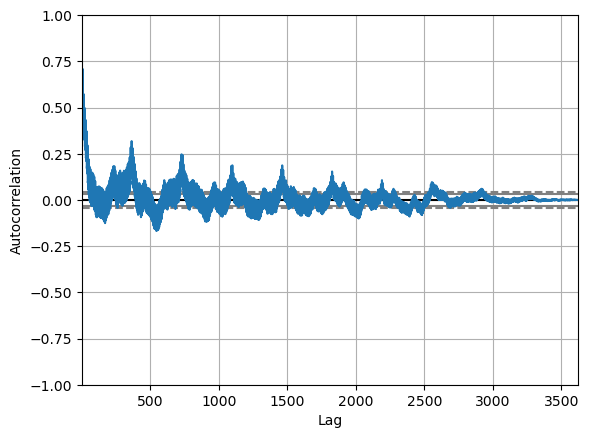

In [21]:
# Autocorrelation of the series
pd.plotting.autocorrelation_plot(accidentslog);

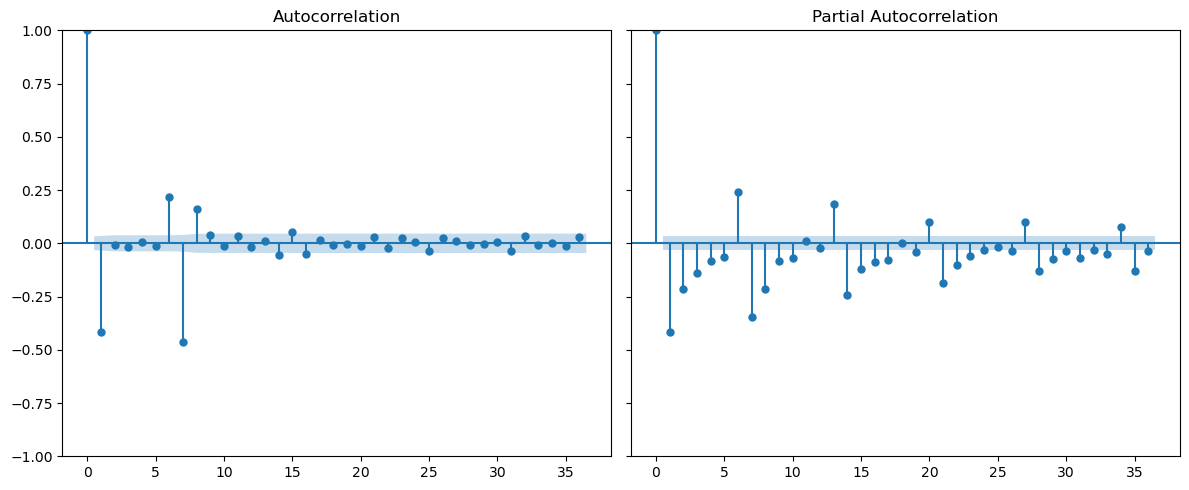

In [22]:
# Double differencing process
accidentslog_1 = accidentslog.diff().dropna() # 1st order differencing
accidentslog_2 = accidentslog_1.diff(periods = season).dropna() # 7 order difference

# Plot on 36 lags the simple and partial autocorrelograms of the doubly differenced time series
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)

plot_acf(accidentslog_2, lags = 36, ax=ax1)
plot_pacf(accidentslog_2, lags = 36, ax=ax2)
plt.tight_layout()
#plt.savefig('../plots/autocorrelation.png')

Testing a SARIMA model with different parameters

In [45]:
import warnings
warnings.filterwarnings('ignore')

def find_best_sarima(accidentslog, p_values, d_values, q_values, P_values, D_values, Q_values, S=season, njobs=10):
    best_aic = float('inf')
    best_order = None
    best_seasonal_order = None

    def evaluate_params(params):
        p, d, q, P, D, Q = params
        try:
            model = sm.tsa.SARIMAX(accidentslog,
                                   order=(p, d, q),
                                   seasonal_order=(P, D, Q, S),
                                   enforce_stationarity=False,
                                   enforce_invertibility=False)
            results = model.fit(disp=False)
            return results.aic, (p, d, q), (P, D, Q, S)
        except:
            return float('inf'), None, None

    # Use joblib to parallelize the parameter search
    results = joblib.Parallel(n_jobs=njobs)(
        joblib.delayed(evaluate_params)(params)
        for params in product(p_values, d_values, q_values, P_values, D_values, Q_values)
    )

    # Find the best result among all parallel processes
    for aic, order, seasonal_order in results:
        if aic < best_aic:
            best_aic = aic
            best_order = order
            best_seasonal_order = seasonal_order

    return best_aic, best_order, best_seasonal_order

# Defining a range of the different parameters for the SARIMA model
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
S = season # Seasonality

best_aic, best_order, best_seasonal_order = find_best_sarima(accidentslog, p_values, d_values, q_values, P_values, D_values, Q_values)

# Create the best SARIMA model with the new parameters
best_model = sm.tsa.SARIMAX(accidentslog,
                            order=best_order,
                            seasonal_order=best_seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
# Fit the best model to the data
results = best_model.fit(disp=True)

print('\n')
print('=================================')
print('Best AIC:', best_aic)
print('Best order:', best_order)
print('Best seasonal order:', best_seasonal_order)
print('=================================')
print('\n')

print(results.summary())

/home/pablo/anaconda3/envs/ml_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/pablo/anaconda3/envs/ml_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: Val

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.97078D-01    |proj g|=  1.04503D-01

At iterate    1    f= -2.97244D-01    |proj g|=  4.96228D-02

At iterate    2    f= -2.97633D-01    |proj g|=  8.29994D-02

At iterate    3    f= -2.98861D-01    |proj g|=  1.38341D-01

At iterate    4    f= -2.99647D-01    |proj g|=  9.34594D-02

At iterate    5    f= -3.00111D-01    |proj g|=  1.51833D-02

At iterate    6    f= -3.00152D-01    |proj g|=  1.26541D-02

At iterate    7    f= -3.00195D-01    |proj g|=  1.98469D-02

At iterate    8    f= -3.00304D-01    |proj g|=  3.38979D-02

At iterate    9    f= -3.00532D-01    |proj g|=  4.64039D-02

At iterate   10    f= -3.01037D-01    |proj g|=  5.68915D-02

At iterate   11    f= -3.02170D-01    |proj g|=  6.84227D-02

At iterate   12    f= -3.02209D-01    |proj g|=  1.30548D-01

At iterate   13    f= -3.0

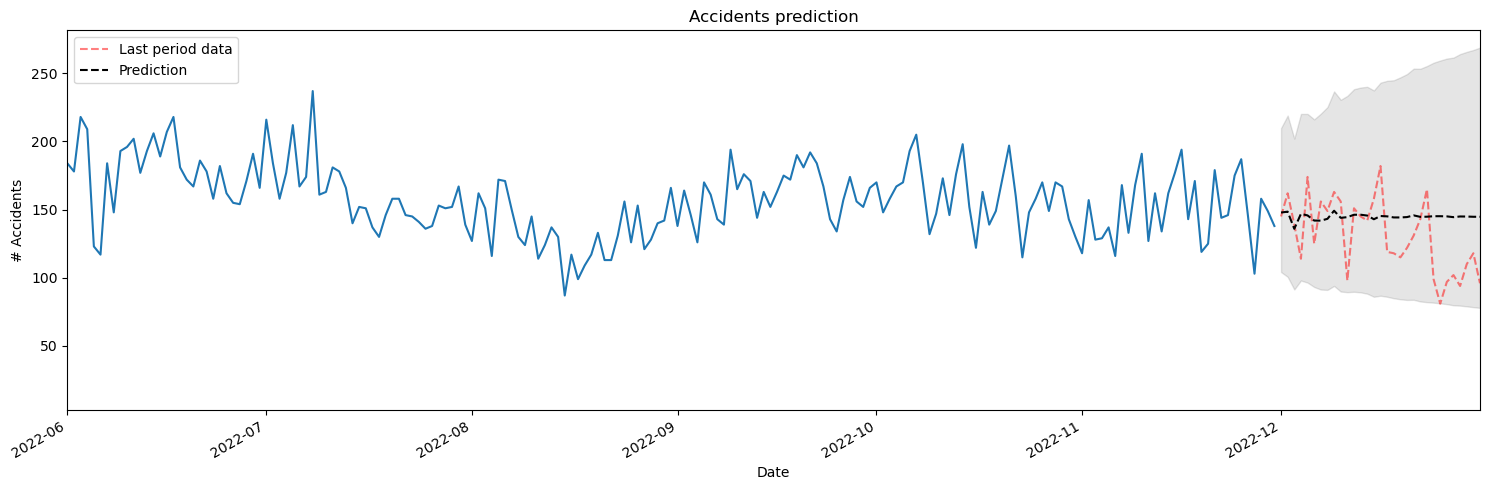

In [46]:
prediction = results.get_forecast(steps=31).summary_frame()  #PForecasting with a confidence interval

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(accidents)
plt.plot(acc_to_pred, 'r--', alpha=0.5, label='Last period data')
prediction = np.exp(prediction) # Exponential Transform

prediction['mean'].plot(ax = ax, style = 'k--', label='Prediction') # Plotting the mean

ax.fill_between(prediction.index, prediction['mean_ci_lower'], prediction['mean_ci_upper'], color='k', alpha=0.1); #Plotting the confidence interval
ax.set_xlim('2022-6-01','2022-12-31')
ax.set_title('Accidents prediction')
ax.set_xlabel('Date'); ax.set_ylabel('# Accidents')
ax.legend(loc=2)
plt.tight_layout()
plt.savefig('../plots/time_series_prediction.png')